# 5 - Neural Net Visualization 

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib notebook

## Helper Functions and Classes

In [2]:
def model2layers(model):
    layers = []

    for i in model.layers:
        name = str(i.with_name_scope).split('.')[-1][:-3]
        if name == 'InputLayer':
            shape = i.input_shape[0][1:]
        elif name == 'MaxPooling2D':
            shape = i.input_shape[1:]
        else:
            shape = i.output_shape[1:]
        layers.append((tuple(shape), name))
        
    return layers


class Layer():    
    
    def __init__(self, shape, name):
        if len(shape) == 1:
            self.shape = (shape[0],1,1)
        elif len(shape) == 2:
            self.shape = (shape[0],shape[1],1)            
        else:
            if name == 'MaxPooling2D' or name == 'AveragePooling2D':
                self.shape = (shape[0],shape[1],1)
            else:
                self.shape = shape
        
        self.x = self.shape[0]
        self.y = self.shape[1]
        self.z = self.shape[2]
        
        self.name = name
        
        if len(self.shape) == 3 and self.shape[-1] == 3:
            self.color = 'rgb' 
            self.marker = 'o'
        else:
            if self.name == 'InputLayer':
                self.color = 'r'
                self.marker = 'o'                
            elif self.name == 'Conv2D':
                self.color = 'y'
                self.marker = '^'
            elif self.name == 'MaxPooling2D' or self.name == 'AveragePooling2D':
                self.color = 'c'
                self.marker = '.'
            else:
                self.color = 'g'
                self.marker = '.'
                
                
def shape2array(shape, layers_len, xy_max):
    x = shape[0]
    y = shape[1]
    z = shape[2]
    
    single_layer = []
    
    if xy_max[0] < x:
        xy_max[0] = x
    if xy_max[1] < y:
        xy_max[1] = y
    
    for k in range(z):        
        
        mx,my,mz = [],[],[]
        
        for i in range(y):            
            ox = [j for j in range(x)]
            mx.append(ox)

        for i in range(y):
            oy = [j for j in (np.ones(x,dtype=int) * i)]
            my.append(oy)

        for i in range(x):
            oz = [j for j in (np.ones(y,dtype=int) * layers_len)]
            mz.append(oz)

        layers_len += 2
        single_layer.append([mx,my,mz])
        
    layers_len += 4
    
    return single_layer, layers_len, xy_max

# Dense layer
def dense(ax, x1=1, x2=1, y1=1, y2=1, x11=1, x21=1, y11=1, y21=1, z1=1, z2=1, c='r', linewidth=.5):
    for i in np.arange(x1,x2+1,1): # 0 1 2 3         X
        for j in np.arange(x11,x21+1,1): # 0 1 2 3   X
            for k in np.arange(y1,y2+1,1): #  1 2
                for l in np.arange(y11,y21+1,1): # 1 2
                    ax.plot([i, j], [z1, z2], [k, l], c=c,linewidth=linewidth)
    
    
def plot_dots(layers_array, layers_name, layers_color, layers_marker, ax, xy_max, linewidth, connection):    
    
    temp = True
    
    last_a,last_b,last_c = [0,0], [0,0], [0,0]
    
    for layer, name, color_in, marker in zip(layers_array, layers_name, layers_color, layers_marker):
        line_x, line_y, line_z = [],[],[]
        color_count = 0
        
        for j in layer:
            my_x, my_y, my_z = [],[],[]    
            
            for k in j[0]:
                k = [a + ((xy_max[0]-len(k))/2) for a in k]                
                my_x += k
            line_x.append([k[0],k[-1]])
            
            temp_list_l=[]            
            for l in j[1]:
                l = [b + ((xy_max[1]-(j[1][-1][-1]+1))/2) for b in l]
                my_y += l
                temp_list_l.append(l[0])            
            line_y.append([temp_list_l[0],temp_list_l[-1]])
            
            for k in j[2]:
                my_z += k
            line_z.append([k[0],k[-1]])
            
            if color_in == 'rgb':
                color = color_in[color_count]
                color_count+=1
            else:
                color = color_in
            
            ax.scatter(my_x, my_z, my_y, c=color, marker=marker, s=20)
            
        if connection:
            if name == 'Dense' or name == 'Flatten':       
                for c in line_z:
                    a,b,c = line_x[0],line_y[0], c
                    if temp:
                        temp = False
                        last_a,last_b,last_c = a,b,c
                        continue

                    if color_in == 'rgb':
                        color = color_in[color_count]
                        color_count+=1
                    else:
                        color = color_in
                    dense(ax, a[0],a[1],b[0],b[1], last_a[0],last_a[1],last_b[0],last_b[1],c[0],last_c[0], c=color, linewidth=linewidth)                
                    last_a,last_b,last_c = a,b,c   

## Define neuralplot() Function 

In [3]:
def neuralplot(model, grid=True, connection=True, linewidth=0.1):
    
#     Default mata data
    %matplotlib notebook
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    layers_len = 0
    layers_array = []
    layers_name = []
    layers_color = []
    layers_marker = []    
    xy_max = [0, 0]
    
#     convert model to layers
    layers = model2layers(model)
    
#     create layers array
    for lay in layers:   
        obj = Layer(lay[0], lay[1])
        single_layer, layers_len, xy_max = shape2array(obj.shape, layers_len, xy_max)        
        
        layers_array.append(single_layer)        
        layers_name.append(obj.name)
        layers_color.append(obj.color)
        layers_marker.append(obj.marker)
        
#     plot dots and lines
    plot_dots(layers_array, layers_name, layers_color, layers_marker, ax, xy_max, linewidth, connection)
    
    # Hide axes ticks
    if grid == False:
        ax.grid(False)
        plt.axis('off')

    plt.show()
    plt.savefig('fig_new.png', dpi=300)

## Create Neural Natwork Model

In [4]:
X_input = tf.keras.layers.Input(shape=(32,32,3))

X = tf.keras.layers.Conv2D(4, 3, activation='relu')(X_input)
X = tf.keras.layers.MaxPool2D(2,2)(X)
X = tf.keras.layers.Conv2D(16, 3, activation='relu')(X)
X = tf.keras.layers.MaxPool2D(2,2)(X)
X = tf.keras.layers.Conv2D(8, 3, activation='relu')(X)
X = tf.keras.layers.MaxPool2D(2,2)(X)

X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dense(10, activation='relu')(X)
X = tf.keras.layers.Dense(2, activation='softmax')(X)

model = tf.keras.models.Model(inputs=X_input, outputs=X)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 4)         112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 16)        592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 8)           1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 8)          

<IPython.core.display.Javascript object>


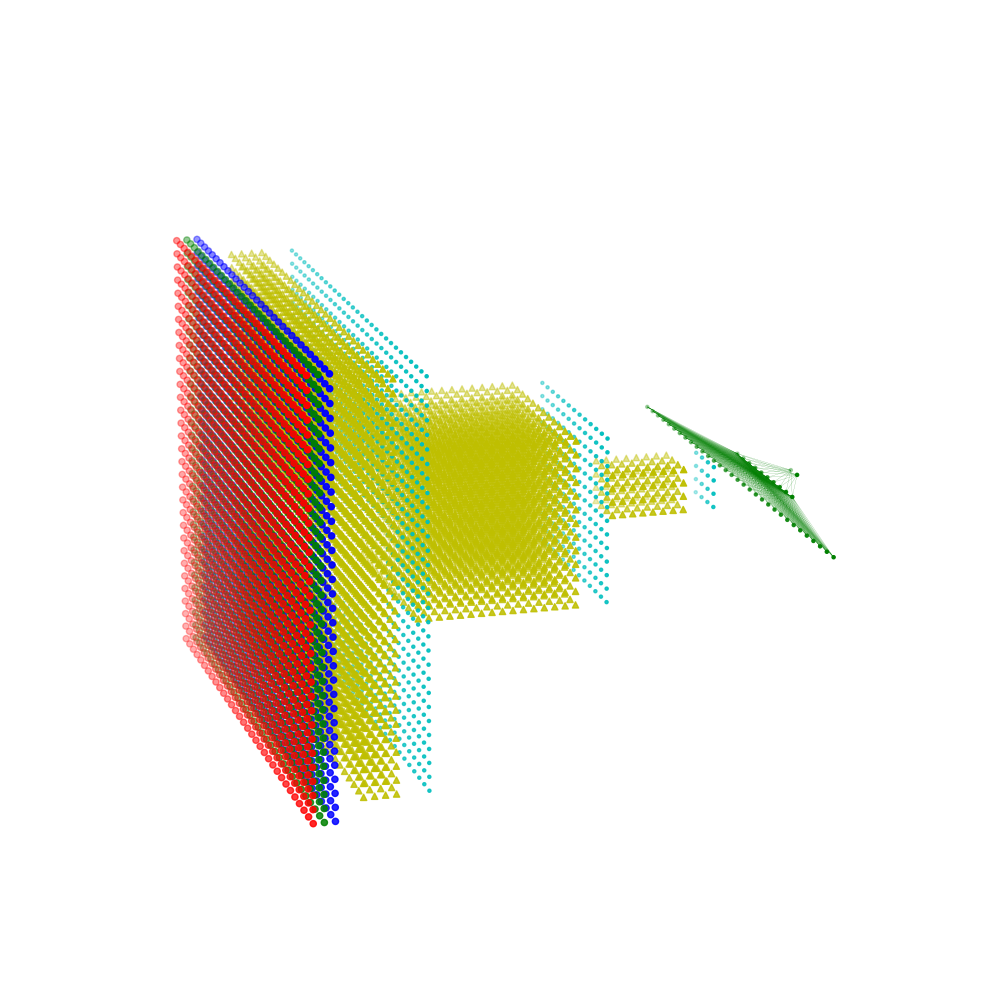

In [5]:
neuralplot(model, grid=False, connection=True, linewidth=.1)

## Plot the model

<IPython.core.display.Javascript object>


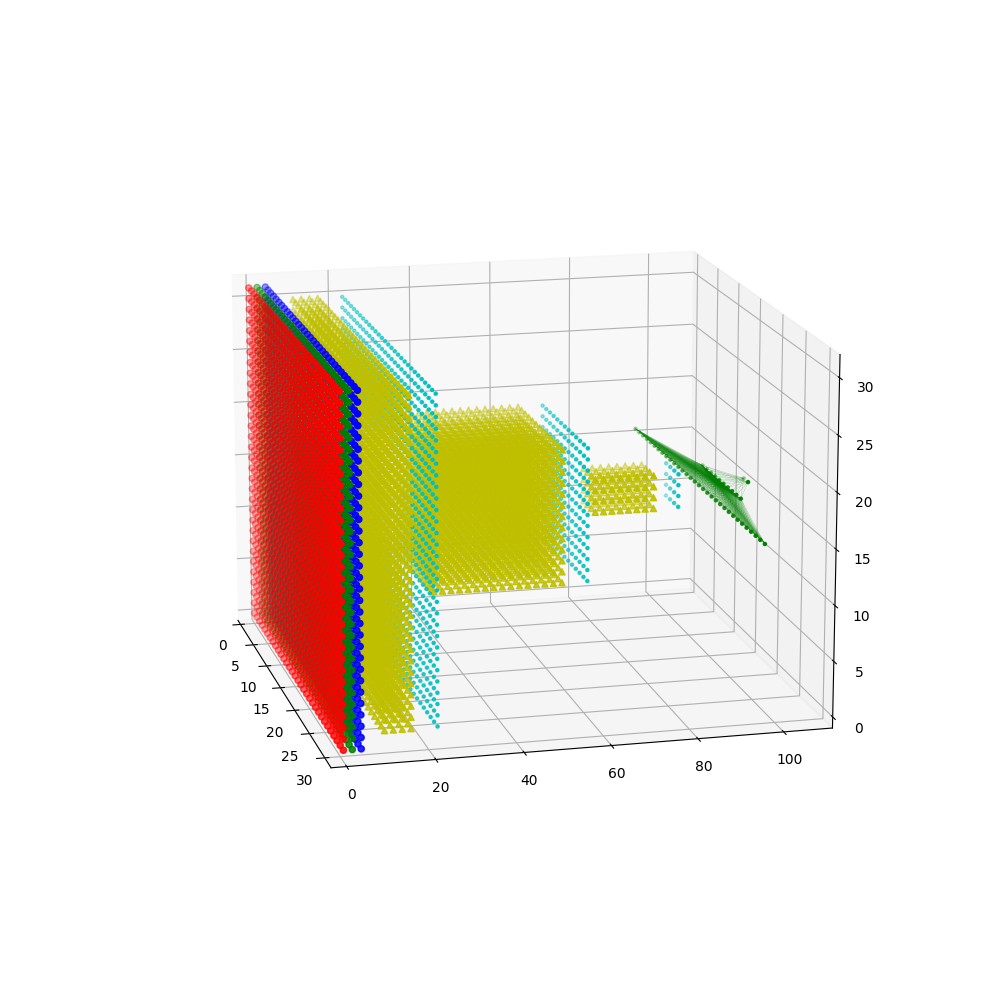

In [6]:
neuralplot(model, grid=True, connection=True, linewidth=.1)